## Zero deforestation mission

Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from fastai.vision.all import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.getcwd()
os.chdir("./drive/MyDrive/Hackaton")
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1hvvPMocJtQD5ZhgmaJGBhgJ0VwkQzV3v/Hackaton'

In [67]:
train = pd.read_csv('train.csv')
test =pd.read_csv('test.csv')

Data Unbalance Visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


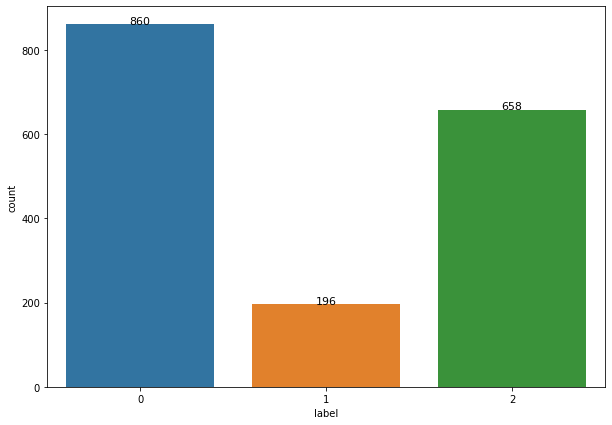

In [68]:
countplt, ax = plt.subplots(figsize = (10,7))
ax = sns.countplot(train['label']);

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

Data preparation

In [76]:
Xtrain=train.iloc[:,1:-2]
ytrain=train.iloc[:,0]

Xtest=test.iloc[:,0:-2]

In [80]:
df = pd.DataFrame([train["example_path"], train["label"]]).transpose()

SVM Model creation

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

param_grid={'gamma':[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]}
clasificadores = GridSearchCV(svm.SVC(kernel='rbf'), param_grid,cv=10,scoring="f1_macro",verbose=2)
clasificadores.fit(Xtrain,ytrain)


Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.01, gamma=0.03; total time=   0.1s
[CV] END .................................C=0.

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
                         'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]},
             scoring='f1_macro', verbose=2)

Loading of models and execution of predictions in train for the ensemble.

In [71]:
predicciones=clasificadores.predict(Xtrain)

from sklearn.metrics import f1_score
f1_score(ytrain, predicciones, average='macro')

0.7470028086725251

In [88]:
prediccionesSVC=clasificadores.predict(Xtrain)

#Resnet34
learnerR34=load_learner("model_resnet34.pkl", cpu=False)
prediccionesR34=[]
#Resnet50
learnerR50=load_learner("model_resnet50.pkl", cpu=False)
prediccionesR50=[]
#Densenet121
learnerD121=load_learner("model_densenet121.pkl", cpu=False)
prediccionesD121=[]
#Vgg_16_bn
learnerV16=load_learner("model_vgg16_bn.pkl", cpu=False)
prediccionesV16=[]

In [89]:
from fastprogress.fastprogress import progress_bar
for i in progress_bar(range(Xtrain.shape[0])):
  prediccionesR34.append(learnerR34.predict(df.iloc[i,0])[0])
  prediccionesR50.append(learnerR50.predict(df.iloc[i,0])[0])
  prediccionesD121.append(learnerD121.predict(df.iloc[i,0])[0])
  prediccionesV16.append(learnerV16.predict(df.iloc[i,0])[0])

Output hidden; open in https://colab.research.google.com to view.

In [101]:
Results=pd.DataFrame(data={"SVC":prediccionesSVC,"Resnet34":pd.to_numeric(prediccionesR34),"Resnet50":pd.to_numeric(prediccionesR50),"Densenet121":pd.to_numeric(prediccionesD121),"Vgg_16_bn":pd.to_numeric(prediccionesV16)})

Creation of the ensemble

In [122]:
from sklearn.neighbors import KNeighborsClassifier
ensemble=KNeighborsClassifier()
ensemble.fit(Results,ytrain)

KNeighborsClassifier()

In [123]:
predictTrain=ensemble.predict(Results)
f1_score(ytrain, predictTrain, average='macro')

0.9568663279183666

Obtaining test results

In [138]:
prediccionesSVC=clasificadores.predict(Xtest)
#Resnet34
prediccionesR34=[]
#Resnet50
prediccionesR50=[]
#Densenet121
prediccionesD121=[]
#Vgg_16_bn
prediccionesV16=[]

In [139]:
dfTest = pd.DataFrame([test["example_path"]]).transpose()

In [140]:
from fastprogress.fastprogress import progress_bar
for i in progress_bar(range(dfTest.shape[0])):
  prediccionesR34.append(learnerR34.predict(dfTest.iloc[i,0])[0])
  prediccionesR50.append(learnerR50.predict(dfTest.iloc[i,0])[0])
  prediccionesD121.append(learnerD121.predict(dfTest.iloc[i,0])[0])
  prediccionesV16.append(learnerV16.predict(dfTest.iloc[i,0])[0])

Output hidden; open in https://colab.research.google.com to view.

In [141]:
ResultsTest=pd.DataFrame(data={"SVC":prediccionesSVC,"Resnet34":pd.to_numeric(prediccionesR34),"Resnet50":pd.to_numeric(prediccionesR50),"Densenet121":pd.to_numeric(prediccionesD121),"Vgg_16_bn":pd.to_numeric(prediccionesV16)})

In [142]:
predictTest=ensemble.predict(ResultsTest)
predictTest

array([2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 0, 2, 0,
       1, 0, 1, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2,
       2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 1, 2,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 2, 2, 1, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 2, 2, 2, 0, 0,
       0, 1, 0, 2, 1, 0, 0, 1, 2, 2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2,
       0, 2, 1, 2, 2, 0, 2, 2, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2,
       2, 0, 2, 0, 0, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0,
       0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0, 2, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2,
       2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2, 0,

In [145]:
indx=[]
for i in range(Xtest.shape[0]): 
  numberImg=dfTest.iloc[i,0].split("/")[-1].split(".")[0]
  indx.append(int(numberImg))

In [147]:
yTest=pd.DataFrame(data={'target':predictTest},index=indx)
yTest=yTest.sort_index()
yTest

,target
1,2
4,1
6,0
9,1
15,0
...,...
2341,0
2342,0
2345,2
2347,2


In [148]:
yTest.to_csv("predictions.csv")

In [150]:
yTest.to_json("predictions.json")